In [ ]:
!pip install -U transformers
!pip install -U datasets
!pip install tensorboard
!pip install sentencepiece
!pip install accelerate
!pip install evaluate
!pip install rouge_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
MODEL = 't5-base'
BATCH_SIZE = 4
NUM_PROCS = 4
EPOCHS = 10
OUT_DIR = 'results_t5base'
MAX_LENGTH = 512 # Maximum context length to consider while preparing dataset.

In [ ]:
import wandb

# Initialize WandB before starting the training
wandb.init(project="t5-bbc-summary", name="t5-finetune", config={
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "learning_rate": 0.0001,
    "max_input_length": MAX_LENGTH,
    "max_target_length": 50
})

wandb.login()  # Will prompt for API key once


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cshreethu_csd226712 (stejasvi_cse2005b2-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
import torch
import random
import pprint
import evaluate
import numpy as np

from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset

In [ ]:
pp = pprint.PrettyPrinter()

In [ ]:
dataset = load_dataset('gopalkalpande/bbc-news-summary', split='train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

bbc-news-summary.csv:   0%|          | 0.00/7.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2224 [00:00<?, ? examples/s]

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def generate_summary(text, model, tokenizer, device, max_input_length=512, max_output_length=150):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)
    summary_ids = model.generate(inputs, max_length=max_output_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


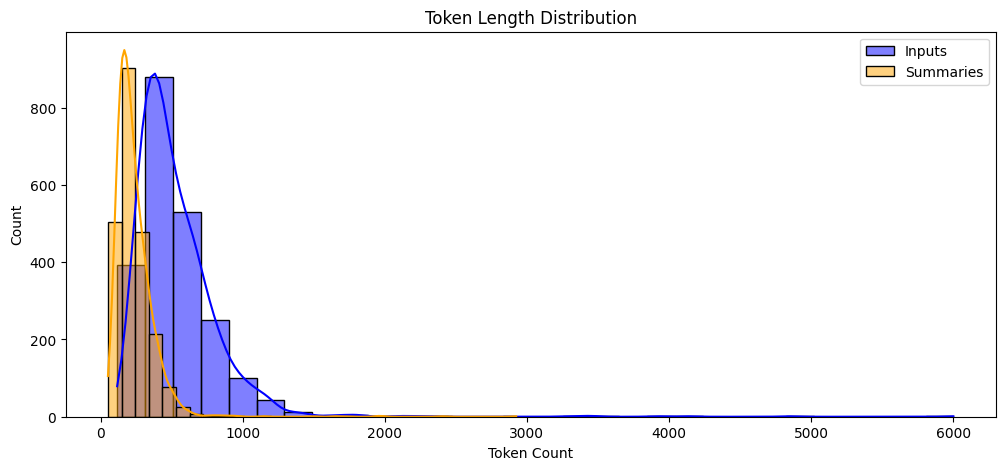

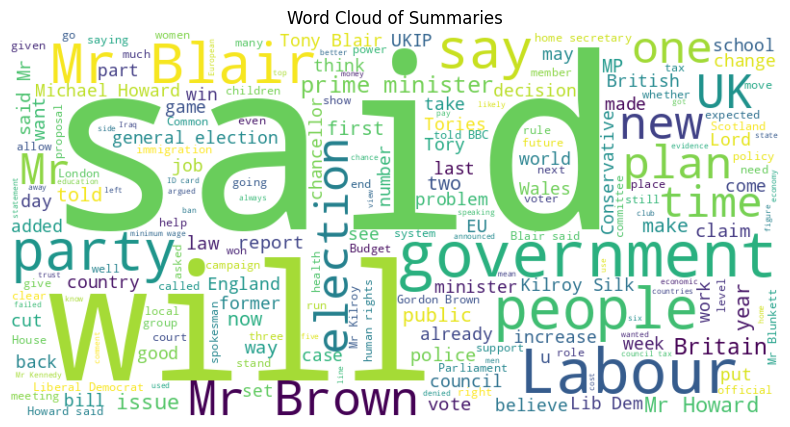

In [ ]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Access the 'Articles' column instead of 'Article'
input_lengths = [len(tokenizer.encode(text)) for text in dataset['Articles']]
target_lengths = [len(tokenizer.encode(text)) for text in dataset['Summaries']]

# Histogram
plt.figure(figsize=(12,5))
sns.histplot(input_lengths, bins=30, kde=True, color='blue', label='Inputs')
sns.histplot(target_lengths, bins=30, kde=True, color='orange', label='Summaries')
plt.legend()
plt.title("Token Length Distribution")
plt.xlabel("Token Count")
plt.show()

# WordCloud of summaries
# Assuming 'summary' should be 'Summaries' here as well, based on dataset structure
# Fixed: Access 'Summaries' directly from the dataset
text_corpus = " ".join(dataset['Summaries'][:500])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Summaries")
plt.show()

In [ ]:
full_dataset = dataset.train_test_split(test_size=0.2, shuffle=True)

In [ ]:
dataset_train = full_dataset['train']
dataset_valid = full_dataset['test']

In [ ]:
print(dataset_train)
print(dataset_valid)

Dataset({
    features: ['File_path', 'Articles', 'Summaries'],
    num_rows: 1779
})
Dataset({
    features: ['File_path', 'Articles', 'Summaries'],
    num_rows: 445
})


In [ ]:
def find_longest_length(dataset):
    """
    Find the longest article and summary in the entire training set.
    """
    max_length = 0
    counter_4k = 0
    counter_2k = 0
    counter_1k = 0
    counter_500 = 0
    for text in dataset:
        corpus = [
            word for word in text.split()
        ]
        if len(corpus) > 4000:
            counter_4k += 1
        if len(corpus) > 2000:
            counter_2k += 1
        if len(corpus) > 1000:
            counter_1k += 1
        if len(corpus) > 500:
            counter_500 += 1
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length, counter_4k, counter_2k, counter_1k, counter_500

longest_article_length, counter_4k, counter_2k, counter_1k, counter_500 = find_longest_length(dataset_train['Articles'])
print(f"Longest article length: {longest_article_length} words")
print(f"Artciles larger than 4000 words: {counter_4k}")
print(f"Artciles larger than 2000 words: {counter_2k}")
print(f"Artciles larger than 1000 words: {counter_1k}")
print(f"Artciles larger than 500 words: {counter_500}")
longest_summary_length, counter_4k, counter_2k, counter_1k, counter_500 = find_longest_length(dataset_train['Summaries'])
print(f"Longest summary length: {longest_summary_length} words")
print(f"Summaries larger than 4000 words: {counter_4k}")
print(f"Summaries larger than 2000 words: {counter_2k}")
print(f"Summaries larger than 1000 words: {counter_1k}")
print(f"Summaries larger than 500 words: {counter_500}")

Longest article length: 4377 words
Artciles larger than 4000 words: 1
Artciles larger than 2000 words: 7
Artciles larger than 1000 words: 20
Artciles larger than 500 words: 352
Longest summary length: 2073 words
Summaries larger than 4000 words: 0
Summaries larger than 2000 words: 1
Summaries larger than 1000 words: 7
Summaries larger than 500 words: 15


In [ ]:
def find_avg_sentence_length(dataset):
    """
    Find the average sentence in the entire training set.
    """
    sentence_lengths = []
    for text in dataset:
        corpus = [
            word for word in text.split()
        ]
        sentence_lengths.append(len(corpus))
    return sum(sentence_lengths)/len(sentence_lengths)

avg_article_length = find_avg_sentence_length(dataset_train['Articles'])
print(f"Average article length: {avg_article_length} words")
avg_summary_length = find_avg_sentence_length(dataset_train['Summaries'])
print(f"Averrage summary length: {avg_summary_length} words")

Average article length: 382.39966273187184 words
Averrage summary length: 166.31646992692524 words


In [ ]:
from transformers import T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained("t5-base")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: T5-base")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Batch Size: 4, Epochs: 10, Max Input Length: 512, Max Target Length: 50")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model: T5-base
Total Parameters: 222,903,552
Trainable Parameters: 222,903,552
Batch Size: 4, Epochs: 10, Max Input Length: 512, Max Target Length: 50


In [ ]:
# Function to convert text data into model inputs and targets
def preprocess_function(examples):
    inputs = [f"summarize: {article}" for article in examples['Articles']]
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_LENGTH,
        truncation=True,
        padding='max_length'
    )

    # Set up the tokenizer for targets
    targets = [summary for summary in examples['Summaries']]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=MAX_LENGTH,
            truncation=True,
            padding='max_length'
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the function to the whole dataset
tokenized_train = dataset_train.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)
tokenized_valid = dataset_valid.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)

Map (num_proc=4):   0%|          | 0/1779 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map (num_proc=4):   0%|          | 0/445 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

222,903,552 total parameters.
222,903,552 training parameters.


In [ ]:
rouge = evaluate.load("rouge")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions[0], eval_pred.label_ids

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        rouge_types=[
            'rouge1',
            'rouge2',
            'rougeL'
        ]
    )

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak.
    This is a workaround to avoid storing too many tensors that are not needed.
    """
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels

In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=OUT_DIR,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=200,
    save_strategy='epoch',
    save_total_limit=2,
    learning_rate=0.0001,
    dataloader_num_workers=4,
    report_to=['tensorboard', 'wandb'],  # Enable WandB logging
    run_name="t5-bbc-summary",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics
)

# Start training
history = trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Gen Len
200,0.542400,0.355815,0.903800,0.833700,0.886500,227.184300
400,0.348100,0.310460,0.912100,0.844100,0.896200,227.811200
600,0.304900,0.299524,0.914400,0.850200,0.899900,227.811200
800,0.309500,0.289157,0.916100,0.851700,0.901100,227.811200
1000,0.313000,0.283446,0.917400,0.854000,0.903000,227.811200
1200,0.244200,0.280089,0.918600,0.856400,0.904400,227.811200
1400,0.270000,0.278570,0.919800,0.857800,0.905400,227.811200
1600,0.441900,0.277252,0.919900,0.857600,0.905800,227.811200
1800,0.247400,0.276500,0.920700,0.859300,0.906400,227.811200
2000,0.329400,0.275910,0.921300,0.859500,0.907000,227.811200


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load pretrained T5 (no fine-tuning)
baseline_model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)
baseline_tokenizer = T5Tokenizer.from_pretrained("t5-base")

def get_baseline_summary(text):
    inputs = baseline_tokenizer("summarize: " + text, return_tensors="pt", truncation=True, max_length=512).to(device)
    summary_ids = baseline_model.generate(inputs["input_ids"], max_length=50, num_beams=4, early_stopping=True)
    return baseline_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Example
# Access the 'Articles' column from the dataset_valid (test split)
sample = dataset_valid[0]['Articles']
print("Original Text:\n", sample)
print("\nBaseline Summary:\n", get_baseline_summary(sample))
print("\nFine-tuned Summary:\n", generate_summary(sample, model, tokenizer, device)) # Added required arguments

Original Text:
 European medal chances improve..What have the European Indoor trials told us? Well, I think we could be heading to the European Championships with half a dozen medal prospects...It was good to see athletes beginning to make steps forward, to see a few new faces and there were lots of personal bests kicking around...The best performance on the track for me was Sarah Claxton's win in the 60m hurdles. Running sub-eight seconds twice in a week puts her right up there and if she repeats that in Madrid she will be close to picking up a medal. But what was great about Sunday's performance was that she was under pressure to produce the goods when it counted. Diane Allahgreen has been our best hurdler for some time now and I think she was surprised to be beaten by Sarah. And knowing that she got the better of Diane in a head-to-head race will give Sarah confidence. In the men's race on Saturday, Allan Scott was right in there and there is definitely more to come from him. In fac

In [ ]:
samples = random.sample(range(len(dataset_valid)), 3) # Use dataset_valid instead of dataset['test']

for idx in samples:
    input_text = dataset_valid[idx]['Articles'] # Access 'Articles' from dataset_valid
    target_summary = dataset_valid[idx]['Summaries'] # Access 'Summaries' from dataset_valid

    print(f"\nExample {idx+1}")
    print("="*60)
    print("Input Dialogue:\n", input_text[:500], "...")  # Truncated for display
    print("\nTarget Summary:\n", target_summary)
    print("\nPretrained Summary:\n", get_baseline_summary(input_text))
    print("\nFine-tuned Summary:\n", generate_summary(input_text, model, tokenizer, device)) # Added required arguments


Example 328
Input Dialogue:
 Kilroy names election seat target..Ex-chat show host Robert Kilroy-Silk is to contest the Derbyshire seat of Erewash at the next general election...Labour's Elizabeth Blackman won the seat in 1997 and has a 6,932 majority. She says she will fight on her record "as a hard-working constituency MP". Mr Kilroy-Silk announced his plans a day after launching his new party, Veritas, the Latin for truth. The East Midlands MEP, who quit the UK Independence Party, wants his new group to "change the face"  ...

Target Summary:
 UKIP's leader, Roger Knapman, has said he is glad to see the back of Mr Kilroy-Silk."He has remarkable ability to influence people but, sadly, after the [European] election it became clear that he was more interested in the Robert Kilroy-Silk Party than the UK Independence Party so it was nice knowing him, now 'goodbye'," he said.UKIP leader Roger Knapman says he is glad to see the back of Mr Kilroy-Silk.UKIP won 31% of the vote in Erewash in 

In [ ]:
tokenizer.save_pretrained(OUT_DIR)

('results_t5base/tokenizer_config.json',
 'results_t5base/special_tokens_map.json',
 'results_t5base/spiece.model',
 'results_t5base/added_tokens.json')

In [ ]:
!zip -r {OUT_DIR} {OUT_DIR}

  adding: results_t5base/ (stored 0%)
  adding: results_t5base/events.out.tfevents.1745589878.06301a6c1d47.942.0 (deflated 70%)
  adding: results_t5base/added_tokens.json (deflated 83%)
  adding: results_t5base/checkpoint-4450/ (stored 0%)
  adding: results_t5base/checkpoint-4450/training_args.bin (deflated 51%)
  adding: results_t5base/checkpoint-4450/model.safetensors (deflated 8%)
  adding: results_t5base/checkpoint-4450/config.json (deflated 63%)
  adding: results_t5base/checkpoint-4450/generation_config.json (deflated 29%)
  adding: results_t5base/checkpoint-4450/trainer_state.json (deflated 84%)
  adding: results_t5base/checkpoint-4450/scheduler.pt (deflated 56%)
  adding: results_t5base/checkpoint-4450/optimizer.pt (deflated 8%)
  adding: results_t5base/checkpoint-4450/rng_state.pth (deflated 25%)
  adding: results_t5base/spiece.model (deflated 48%)
  adding: results_t5base/special_tokens_map.json (deflated 85%)
  adding: results_t5base/checkpoint-4005/ (stored 0%)
  adding: res

In [ ]:
# Download data.
!wget "https://www.dropbox.com/scl/fi/561r8pfhem4lu70hf438q/inference_data.zip?rlkey=aedt2saqmmp3a67qc4o34k04y&dl=1" -O inference_data.zip

--2025-04-25 16:11:12--  https://www.dropbox.com/scl/fi/561r8pfhem4lu70hf438q/inference_data.zip?rlkey=aedt2saqmmp3a67qc4o34k04y&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf560cc5e9b90e635d1203bc06c.dl.dropboxusercontent.com/cd/0/inline/CoeuAh04uEZ5GC3zdFskPJiJJw6xjZPQYqCOaaKtsR8arzIiPePqhQEKb2pvXcoTOr05z_tkFFmdshrJmN8gshGlbPoLFdlhG6dhxL9pDP7y7a4PSduVaJ39CXLUqLScs579wXpPjcGbvSWamfCDVfIh/file?dl=1# [following]
--2025-04-25 16:11:13--  https://ucf560cc5e9b90e635d1203bc06c.dl.dropboxusercontent.com/cd/0/inline/CoeuAh04uEZ5GC3zdFskPJiJJw6xjZPQYqCOaaKtsR8arzIiPePqhQEKb2pvXcoTOr05z_tkFFmdshrJmN8gshGlbPoLFdlhG6dhxL9pDP7y7a4PSduVaJ39CXLUqLScs579wXpPjcGbvSWamfCDVfIh/file?dl=1
Resolving ucf560cc5e9b90e635d1203bc06c.dl.dropboxusercontent.com (ucf560cc5e9b90e635d1203bc06c.dl.dropboxusercontent.com)

In [ ]:
!unzip inference_data.zip

Archive:  inference_data.zip
  inflating: inference_data/file_1.txt  
  inflating: inference_data/file_2.txt  


In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

import glob

In [ ]:
model_path = f"{OUT_DIR}/checkpoint-4450"  # the path where you saved your model
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(OUT_DIR)

In [ ]:
def summarize_text(text, model, tokenizer, max_length=512, num_beams=5):
    # Preprocess the text
    inputs = tokenizer.encode(
        "summarize: " + text,
        return_tensors='pt',
        max_length=max_length,
        truncation=True
    )

    # Generate the summary
    summary_ids = model.generate(
        inputs,
        max_length=50,
        num_beams=num_beams,
        # early_stopping=True,
    )

    # Decode and return the summary
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [ ]:
for file_path in glob.glob('inference_data/*.txt'):
    with open(file_path, 'r') as file:
        text = file.read()
    summary = summarize_text(text, model, tokenizer)
    pp.pprint(summary)
    print('-'*75)

('Brockmann quit as OpenAI president after Altman was fired. Microsoft has '
 'hired Sam Altman to power up its innovation in artificial intelligence after '
 'the co-founder of OpenAI was ousted as CEO in a chaotic boardroom coup on '
 'Friday')
---------------------------------------------------------------------------
('Sam Altman — the leader of one of the world’s most influential AI companies, '
 'OpenAI, and perhaps the most visible figure in the space — was fired Friday '
 'night by the startup’s board in a surprise move.')
---------------------------------------------------------------------------


In [ ]:
# Evaluate final performance
final_metrics = trainer.evaluate()
print("Final Evaluation Metrics:", final_metrics)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Final Evaluation Metrics: {'eval_loss': 0.27723389863967896, 'eval_rouge1': 0.9244, 'eval_rouge2': 0.8664, 'eval_rougeL': 0.9106, 'eval_gen_len': 227.8112, 'eval_runtime': 80.6685, 'eval_samples_per_second': 5.516, 'eval_steps_per_second': 1.388, 'epoch': 10.0}


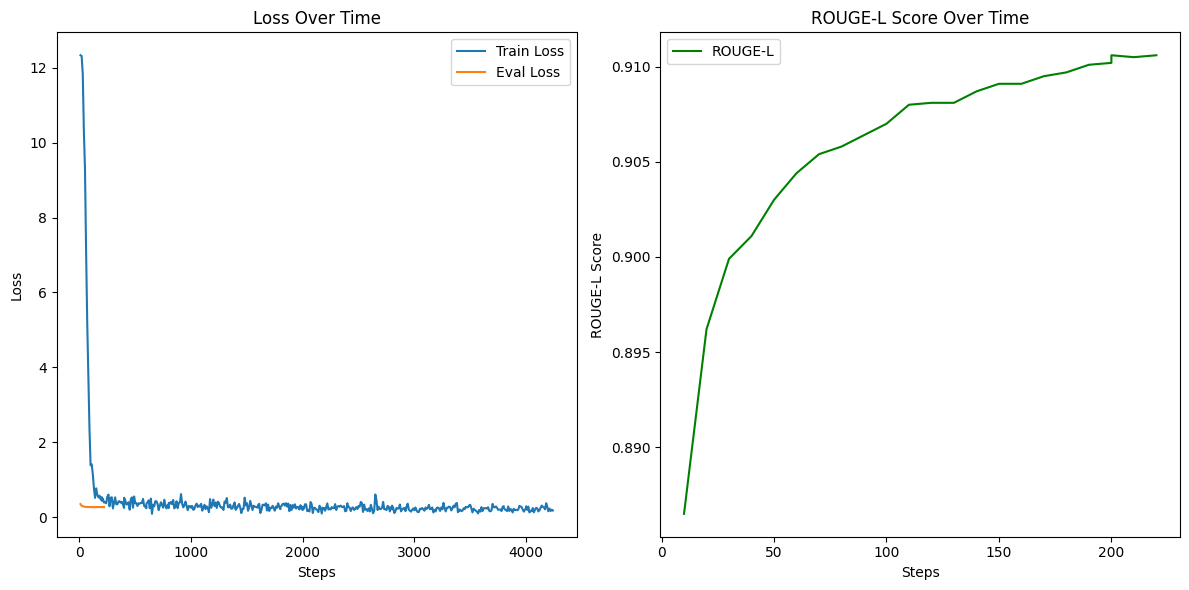

In [ ]:
import matplotlib.pyplot as plt

# Example: Extract metrics from the trainer state
log_history = trainer.state.log_history

# Separate logs
train_loss = [log["loss"] for log in log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
rouge_l = [log["eval_rougeL"] for log in log_history if "eval_rougeL" in log]
steps = [log["step"] for log in log_history if "step" in log]

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(steps[:len(train_loss)], train_loss, label="Train Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps[:len(rouge_l)], rouge_l, color='green', label="ROUGE-L")
plt.xlabel("Steps")
plt.ylabel("ROUGE-L Score")
plt.title("ROUGE-L Score Over Time")
plt.legend()

plt.tight_layout()
plt.show()
